# 日本国債イールドカーブの主成分分析

このノートブックでは、日本国債の金利データに対して主成分分析を実行します。

## アプローチ（案B: ビニングなし - 完全な和集合）
1. 分析期間の全銘柄から残存期間の**完全な和集合**を作成（ビニングなし）
2. 各日付で銘柄名から発行年限を抽出し、同一残存期間では発行年限が最小のカレント債を選択
3. 残存期間の和集合の各点について、スプライン補間で利回りを算出
4. 主成分分析を実行し、指定成分数で復元
5. 元データと復元データの差分を可視化

**注意**: 残存期間の和集合は数千〜1万次元になる可能性がありますが、PCAは効率的に処理できます。

In [68]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
import re
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_root)

from data.utils.database_manager import DatabaseManager

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic']
plt.rcParams['axes.unicode_minus'] = False

## 1. データ取得関数

In [ ]:
def fetch_bond_data(db_manager: DatabaseManager, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Supabaseから国債データを取得（ページング対応）
    
    Args:
        db_manager: DatabaseManagerインスタンス
        start_date: 開始日 (YYYY-MM-DD)
        end_date: 終了日 (YYYY-MM-DD)
    
    Returns:
        pd.DataFrame: 国債データ
    """
    import requests
    
    url = f'{db_manager.supabase_url}/rest/v1/bond_data'
    
    all_data = []
    offset = 0
    limit = 1000  # ページサイズ
    
    print(f"🔄 データ取得中 ({start_date} ~ {end_date})...")
    
    while True:
        # trade_dateの条件を正しく設定
        query_params = [
            f'select=trade_date,bond_name,due_date,ave_compound_yield',
            f'trade_date=gte.{start_date}',
            f'trade_date=lte.{end_date}',
            f'ave_compound_yield=not.is.null',
            f'due_date=not.is.null',
            f'order=trade_date.asc,due_date.asc',
            f'offset={offset}',
            f'limit={limit}'
        ]
        
        full_url = f"{url}?{'&'.join(query_params)}"
        response = requests.get(full_url, headers=db_manager.headers)
        
        if response.status_code != 200:
            print(f"❌ データ取得失敗: {response.status_code}")
            print(f"   URL: {full_url}")
            print(f"   Response: {response.text[:500]}")
            break
        
        data = response.json()
        
        if not data:  # データなし = 終了
            break
        
        all_data.extend(data)
        
        # 進捗表示
        if len(all_data) % 5000 == 0:
            print(f"   取得済み: {len(all_data)}件...")
        
        # 最後のページの場合は終了
        if len(data) < limit:
            break
        
        offset += limit
    
    if not all_data:
        print(f"⚠️ データが見つかりませんでした")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_data)
    
    # 日付型に変換
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df['due_date'] = pd.to_datetime(df['due_date'])
    
    # 残存期間を計算（年単位、高精度）
    df['maturity_years'] = (df['due_date'] - df['trade_date']).dt.days / 365.25

    # 異常値除去
    df = df[(df['maturity_years'] > 0) & (df['maturity_years'] <= 50)]
    df = df[(df['ave_compound_yield'] > 0) & (df['ave_compound_yield'] < 10)]

    print(f"✅ データ取得完了: {len(df)}件 ({df['trade_date'].min().date()} ~ {df['trade_date'].max().date()})")
    print(f"   ユニーク日付数: {df['trade_date'].nunique()}日")
    return df


def get_analysis_date_range(db_manager: DatabaseManager, reference_date: str, lookback_days: int) -> Tuple[str, str]:
    """
    分析基準日から過去N営業日分のデータ範囲を計算
    
    Args:
        db_manager: DatabaseManagerインスタンス
        reference_date: 分析基準日 (YYYY-MM-DD)
        lookback_days: 遡る営業日数
    
    Returns:
        (開始日, 終了日) のタプル
    """
    ref_date = pd.to_datetime(reference_date)
    # 営業日100日分 ≒ カレンダー日で約140-150日
    # 余裕を持って2倍の期間を取得（土日祝を考慮）
    # 100営業日 ≒ 200カレンダー日程度を見込む
    calendar_days_buffer = int(lookback_days * 2.0)
    start_date = (ref_date - timedelta(days=calendar_days_buffer)).date()
    end_date = ref_date.date()
    
    return str(start_date), str(end_date)

## 2. カレント債判定関数

In [ ]:
def extract_bond_maturity(bond_name: str) -> Optional[int]:
    """
    銘柄名から発行年限を抽出
    
    Args:
        bond_name: 銘柄名（例: '第369回10年利付国債'）
    
    Returns:
        発行年限（整数）、抽出失敗時はNone
    """
    if bond_name is None or (isinstance(bond_name, float) and pd.isna(bond_name)):
        return None
    
    # パターン: 「XX年」を探す
    patterns = [
        r'(\d+)年',  # 基本パターン
        r'(\d+)Year',  # 英語表記
    ]
    
    for pattern in patterns:
        match = re.search(pattern, str(bond_name))
        if match:
            return int(match.group(1))
    
    return None


def select_current_bond(group_df: pd.DataFrame) -> pd.Series:
    """
    同一残存期間の銘柄群からカレント債を選択
    発行年限が最小のものを選択
    
    Args:
        group_df: 同一残存期間の銘柄データフレーム
    
    Returns:
        カレント債の行（pd.Series）
    """
    if len(group_df) == 1:
        return group_df.iloc[0]
    
    # 発行年限を抽出
    group_df = group_df.copy()
    group_df['bond_maturity'] = group_df['bond_name'].apply(extract_bond_maturity)
    
    # 発行年限が抽出できた銘柄のみ
    valid_bonds = group_df[group_df['bond_maturity'].notna()]
    
    if len(valid_bonds) == 0:
        # 発行年限が抽出できない場合は最初の銘柄を返す
        return group_df.iloc[0]
    
    # 発行年限が最小のものを選択（カレント債）
    min_maturity = valid_bonds['bond_maturity'].min()
    current_bond = valid_bonds[valid_bonds['bond_maturity'] == min_maturity].iloc[0]
    
    return current_bond

## 3. データ前処理関数（案B: ビニングなし）

In [71]:
def build_maturity_union_exact(df: pd.DataFrame, tolerance: float = 0.01) -> np.ndarray:
    """
    残存期間の完全な和集合を作成（ビニングなし）
    非常に近い残存期間（tolerance以内）は同一とみなす
    
    Args:
        df: 国債データフレーム
        tolerance: 同一とみなす残存期間の差（年）
    
    Returns:
        残存期間の和集合（ソート済み配列）
    """
    # 全残存期間を取得
    all_maturities = df['maturity_years'].values
    
    # ソート
    sorted_maturities = np.sort(all_maturities)
    
    # tolerance以内の値をマージ
    maturity_union = []
    current_group = [sorted_maturities[0]]
    
    for mat in sorted_maturities[1:]:
        if mat - current_group[-1] <= tolerance:
            current_group.append(mat)
        else:
            # グループの平均を代表値として追加
            maturity_union.append(np.mean(current_group))
            current_group = [mat]
    
    # 最後のグループを追加
    maturity_union.append(np.mean(current_group))
    
    maturity_union = np.array(maturity_union)
    
    # 0以下を除外
    maturity_union = maturity_union[maturity_union > 0]
    
    print(f"✅ 残存期間の和集合作成完了（ビニングなし）")
    print(f"   次元数: {len(maturity_union)}個の残存期間点")
    print(f"   範囲: {maturity_union.min():.4f}年 ~ {maturity_union.max():.4f}年")
    print(f"   Tolerance: {tolerance}年")
    
    return maturity_union


def prepare_daily_yield_vector_exact(daily_df: pd.DataFrame, 
                                      maturity_union: np.ndarray,
                                      tolerance: float = 0.01) -> Optional[np.ndarray]:
    """
    1日分のイールドカーブをベクトル化（ビニングなし）
    
    Args:
        daily_df: 1日分の国債データ
        maturity_union: 残存期間の和集合
        tolerance: 同一残存期間とみなす許容誤差
    
    Returns:
        利回りベクトル（maturity_unionと同じ長さ）
    """
    if len(daily_df) < 3:
        # スプライン補間には最低3点必要
        return None
    
    daily_df = daily_df.copy()
    
    # 各和集合の残存期間点について、tolerance以内の銘柄をグループ化
    selected_data = []
    
    for target_maturity in maturity_union:
        # tolerance以内の銘柄を抽出
        mask = np.abs(daily_df['maturity_years'] - target_maturity) <= tolerance
        candidates = daily_df[mask]
        
        if len(candidates) > 0:
            # カレント債を選択
            current_bond = select_current_bond(candidates)
            selected_data.append({
                'maturity': target_maturity,
                'yield': current_bond['ave_compound_yield'],
                'is_actual': True  # 実データ
            })
    
    if len(selected_data) < 3:
        return None
    
    selected_df = pd.DataFrame(selected_data)
    
    # スプライン補間で全和集合点の利回りを算出
    x = selected_df['maturity'].values
    y = selected_df['yield'].values
    
    try:
        # 線形補間（外挿も可能）
        f = interp1d(x, y, kind='linear', fill_value='extrapolate', bounds_error=False)
        
        # 和集合の各点で評価
        yield_vector = f(maturity_union)
        
        # 異常値チェック（外挿で異常値が出ることがあるため）
        yield_vector = np.clip(yield_vector, 0, 10)
        
        return yield_vector
    
    except Exception as e:
        print(f"⚠️ 補間エラー: {e}")
        return None

## 4. PCA実行関数

In [72]:
def perform_pca(yield_matrix: np.ndarray, n_components: int = 10) -> Tuple[PCA, np.ndarray]:
    """
    主成分分析を実行
    
    Args:
        yield_matrix: 利回り行列（日数 × 残存期間数）
        n_components: 主成分数
    
    Returns:
        (PCAモデル, 主成分得点)
    """
    print(f"\n🔄 PCA実行中...")
    print(f"   入力行列形状: {yield_matrix.shape}")
    
    pca = PCA(n_components=n_components)
    scores = pca.fit_transform(yield_matrix)
    
    print(f"\n✅ PCA実行完了")
    print(f"   主成分数: {n_components}")
    print(f"   累積寄与率:")
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    for i in range(min(5, n_components)):
        print(f"     PC{i+1}: {cumsum[i]*100:.2f}%")
    
    return pca, scores


def reconstruct_yields(pca: PCA, scores: np.ndarray, n_components_use: int) -> np.ndarray:
    """
    指定成分数で利回りを復元
    
    Args:
        pca: PCAモデル
        scores: 主成分得点
        n_components_use: 使用する主成分数
    
    Returns:
        復元された利回り行列
    """
    # 使用する成分のみ抽出
    scores_partial = scores[:, :n_components_use]
    components_partial = pca.components_[:n_components_use, :]
    
    # 復元
    reconstructed = scores_partial @ components_partial + pca.mean_
    
    return reconstructed

## 5. 可視化関数

In [73]:
def plot_reconstruction_error(maturity_union: np.ndarray, 
                              original_yields: np.ndarray,
                              reconstructed_yields: np.ndarray,
                              dates: List[str],
                              plot_dates: List[str],
                              n_components_use: int):
    """
    復元誤差を可視化
    
    Args:
        maturity_union: 残存期間の和集合
        original_yields: 元の利回り行列
        reconstructed_yields: 復元された利回り行列
        dates: 日付リスト
        plot_dates: プロットする日付のリスト（YYYY-MM-DD形式）
        n_components_use: 使用した主成分数
    """
    # 日付をインデックスに変換
    plot_indices = [dates.index(d) for d in plot_dates if d in dates]
    
    if len(plot_indices) == 0:
        print("⚠️ 指定された日付がデータに存在しません")
        return
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 上段: 元の利回りと復元利回り
    ax1 = axes[0]
    for idx in plot_indices:
        date_str = dates[idx]
        # プロット点を間引く（可読性向上）
        step = max(1, len(maturity_union) // 200)
        ax1.plot(maturity_union[::step], original_yields[idx][::step], 'o-', 
                label=f'{date_str} (元データ)', alpha=0.7, markersize=3)
        ax1.plot(maturity_union[::step], reconstructed_yields[idx][::step], 's--', 
                label=f'{date_str} (復元)', alpha=0.7, markersize=3)
    
    ax1.set_xlabel('残存期間（年）', fontsize=12)
    ax1.set_ylabel('利回り（%）', fontsize=12)
    ax1.set_title(f'イールドカーブ: 元データ vs 復元データ（第{n_components_use}主成分まで使用）', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=9, loc='best')
    ax1.grid(True, alpha=0.3)
    
    # 下段: 復元誤差
    ax2 = axes[1]
    for idx in plot_indices:
        date_str = dates[idx]
        error = original_yields[idx] - reconstructed_yields[idx]
        step = max(1, len(maturity_union) // 200)
        ax2.plot(maturity_union[::step], error[::step] * 100, 'o-', 
                label=f'{date_str}', alpha=0.7, markersize=3)  # bpに変換
    
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('残存期間（年）', fontsize=12)
    ax2.set_ylabel('復元誤差（bp）', fontsize=12)
    ax2.set_title(f'復元誤差: 元データ - 復元データ（第{n_components_use}主成分まで使用）', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_pca_components(pca: PCA, maturity_union: np.ndarray, n_components_plot: int = 3):
    """
    主成分ベクトルを可視化
    
    Args:
        pca: PCAモデル
        maturity_union: 残存期間の和集合
        n_components_plot: プロットする主成分数
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # プロット点を間引く（可読性向上）
    step = max(1, len(maturity_union) // 200)
    
    for i in range(n_components_plot):
        ax.plot(maturity_union[::step], pca.components_[i][::step], 'o-', 
                label=f'第{i+1}主成分 ({pca.explained_variance_ratio_[i]*100:.1f}%)', 
                alpha=0.7, markersize=3)
    
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('残存期間（年）', fontsize=12)
    ax.set_ylabel('主成分ベクトル', fontsize=12)
    ax.set_title('主成分ベクトル（固有ベクトル）', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. パラメータ設定

### 📋 ユーザー設定項目
- **REFERENCE_DATE**: 分析基準日（この日のデータを復元する）
- **LOOKBACK_DAYS**: 分析基準日から過去何日分のデータで主成分分析を行うか
- **N_COMPONENTS**: 計算する主成分数
- **N_COMPONENTS_USE**: 復元に使用する主成分数
- **PLOT_DATES**: 可視化する日付のリスト
- **TOLERANCE**: 同一残存期間とみなす許容誤差（年）

In [74]:
# ========================================
# ユーザー設定パラメータ
# ========================================

# 分析基準日（この日から過去を遡る）
REFERENCE_DATE = '2025-10-03'  # YYYY-MM-DD形式で指定

# 分析に使用する過去日数
LOOKBACK_DAYS = 100  # 例: 100日分のデータで主成分分析

# 主成分分析パラメータ
N_COMPONENTS = 10   # 計算する主成分数
N_COMPONENTS_USE = 3  # 復元に使用する主成分数

# 可視化する日付（複数指定可能）
PLOT_DATES = [
    '2025-10-03',  # 分析基準日
    '2025-10-02',  # 前日
    '2025-10-01',  # 前々日
]

# 残存期間の許容誤差（年）
# これより近い残存期間は同一とみなす
TOLERANCE = 0.01  # 0.01年 = 約3.65日

# ========================================

# データベース接続
db_manager = DatabaseManager()

# 日付範囲を計算
start_date, end_date = get_analysis_date_range(db_manager, REFERENCE_DATE, LOOKBACK_DAYS)

print("="*60)
print("日本国債イールドカーブ主成分分析（案B: ビニングなし）")
print("="*60)
print(f"分析基準日: {REFERENCE_DATE}")
print(f"過去遡り日数: {LOOKBACK_DAYS}日")
print(f"データ取得範囲: {start_date} ~ {end_date}")
print(f"主成分数: {N_COMPONENTS}")
print(f"復元使用成分: {N_COMPONENTS_USE}")
print(f"残存期間許容誤差: {TOLERANCE}年")
print(f"可視化日付: {PLOT_DATES}")
print("="*60)

日本国債イールドカーブ主成分分析（案B: ビニングなし）
分析基準日: 2025-10-03
過去遡り日数: 100日
データ取得範囲: 2025-03-17 ~ 2025-10-03
主成分数: 10
復元使用成分: 3
残存期間許容誤差: 0.01年
可視化日付: ['2025-10-03', '2025-10-02', '2025-10-01']


## 7. データ取得と前処理

In [75]:
# データ取得
df_all = fetch_bond_data(db_manager, start_date, end_date)

if len(df_all) == 0:
    raise ValueError("データ取得に失敗しました")

# 日付でフィルタして正確にLOOKBACK_DAYS分を取得
unique_dates = sorted(df_all['trade_date'].unique())
reference_dt = pd.to_datetime(REFERENCE_DATE)

# 分析基準日以前の日付を取得
past_dates = [d for d in unique_dates if d <= reference_dt]

if len(past_dates) == 0:
    raise ValueError(f"分析基準日 {REFERENCE_DATE} のデータが存在しません")

# 過去LOOKBACK_DAYS分を選択
selected_dates = past_dates[-LOOKBACK_DAYS:]
df = df_all[df_all['trade_date'].isin(selected_dates)].copy()

print(f"\n✅ 分析対象データ絞り込み完了")
print(f"   実際の日付数: {len(selected_dates)}日")
print(f"   日付範囲: {selected_dates[0].date()} ~ {selected_dates[-1].date()}")
print(f"   総レコード数: {len(df)}件")

🔄 データ取得中 (2025-03-17 ~ 2025-10-03)...
   取得済み: 5000件...
   取得済み: 10000件...
   取得済み: 15000件...
   取得済み: 20000件...
   取得済み: 25000件...
   取得済み: 30000件...
   取得済み: 35000件...
   取得済み: 40000件...
✅ データ取得完了: 44100件 (2025-03-17 ~ 2025-10-03)
   ユニーク日付数: 137日

✅ 分析対象データ絞り込み完了
   実際の日付数: 100日
   日付範囲: 2025-05-13 ~ 2025-10-03
   総レコード数: 32236件


In [76]:
# 残存期間の完全な和集合作成（ビニングなし）
maturity_union = build_maturity_union_exact(df, tolerance=TOLERANCE)

✅ 残存期間の和集合作成完了（ビニングなし）
   次元数: 225個の残存期間点
   範囲: 1.0348年 ~ 39.7445年
   Tolerance: 0.01年


In [ ]:
# 各日付のイールドカーブをベクトル化
print("\n🔄 各日付のデータをベクトル化中...")

dates = []
yield_vectors = []
failed_dates = []

for i, (trade_date, daily_df) in enumerate(df.groupby('trade_date')):
    yield_vector = prepare_daily_yield_vector_exact(daily_df, maturity_union, tolerance=TOLERANCE)
    
    if yield_vector is not None:
        dates.append(trade_date.strftime('%Y-%m-%d'))
        yield_vectors.append(yield_vector)
    else:
        failed_dates.append(trade_date.strftime('%Y-%m-%d'))
    
    # 進捗表示（10日ごと）
    if (i + 1) % 10 == 0:
        print(f"   処理済み: {i + 1}日分")

# 行列に変換
yield_matrix = np.array(yield_vectors)

print(f"\n✅ データ行列構築完了")
print(f"   形状: {yield_matrix.shape} (日数 × 残存期間点数)")
print(f"   日付範囲: {dates[0]} ~ {dates[-1]}")
print(f"   メモリ使用量: {yield_matrix.nbytes / 1024 / 1024:.2f} MB")

# 失敗した日付の詳細
if failed_dates:
    print(f"\n⚠️ ベクトル化失敗: {len(failed_dates)}日")
    print(f"   最後の10件:")
    for d in failed_dates[-10:]:
        print(f"     {d}")
    
    # 10月のデータが失敗していないか確認
    oct_failed = [d for d in failed_dates if d >= '2025-10-01']
    if oct_failed:
        print(f"\n❌ 10月で失敗した日付:")
        for d in oct_failed:
            # 詳細確認
            daily_df = df[df['trade_date'] == pd.to_datetime(d)]
            print(f"     {d}: {len(daily_df)}件のデータ")
else:
    print(f"\n✅ 全日付のベクトル化成功")

## 8. 主成分分析実行

In [78]:
# 主成分分析実行
pca, scores = perform_pca(yield_matrix, n_components=N_COMPONENTS)


🔄 PCA実行中...
   入力行列形状: (42, 225)

✅ PCA実行完了
   主成分数: 10
   累積寄与率:
     PC1: 55.66%
     PC2: 84.79%
     PC3: 98.61%
     PC4: 99.74%
     PC5: 99.85%


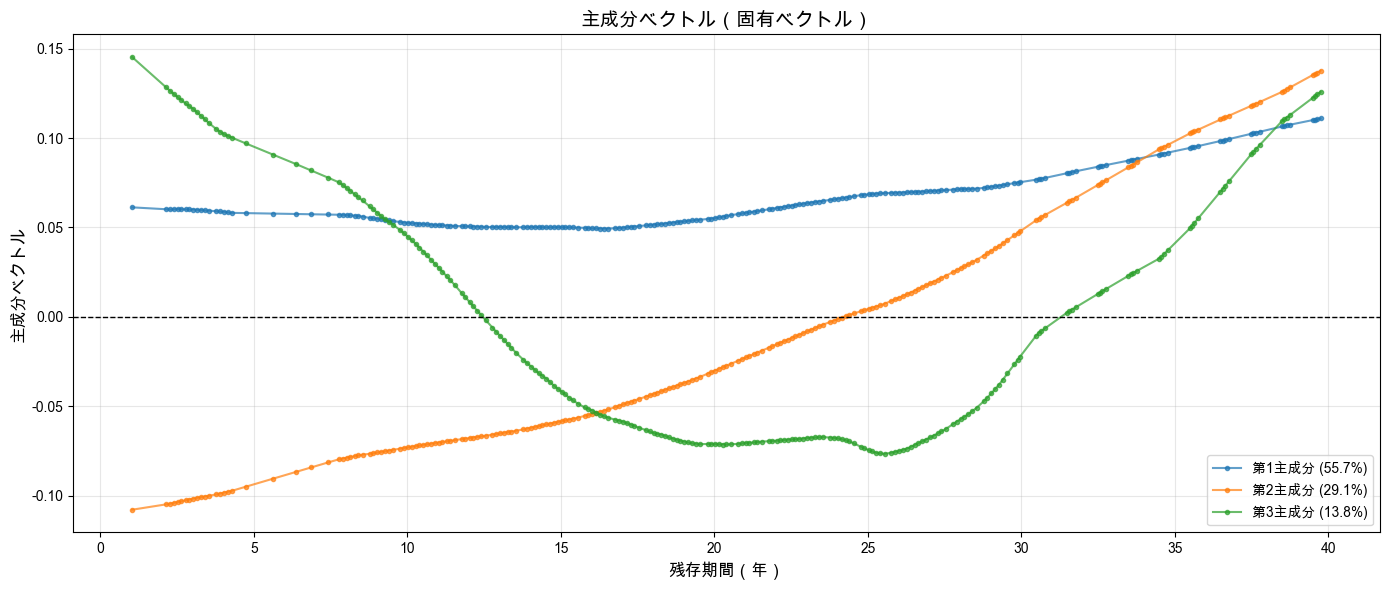

In [79]:
# 主成分ベクトルを可視化
plot_pca_components(pca, maturity_union, n_components_plot=3)

## 9. 利回り復元と誤差可視化

In [80]:
# 指定成分数で復元
reconstructed_yields = reconstruct_yields(pca, scores, n_components_use=N_COMPONENTS_USE)

print(f"\n✅ 利回り復元完了")
print(f"   使用主成分数: {N_COMPONENTS_USE}")
print(f"   復元行列形状: {reconstructed_yields.shape}")


✅ 利回り復元完了
   使用主成分数: 3
   復元行列形状: (42, 225)


In [81]:
# 復元誤差を可視化
print(f"\n📊 可視化する日付: {PLOT_DATES}")

plot_reconstruction_error(
    maturity_union,
    yield_matrix,
    reconstructed_yields,
    dates,
    PLOT_DATES,
    N_COMPONENTS_USE
)


📊 可視化する日付: ['2025-10-03', '2025-10-02', '2025-10-01']
⚠️ 指定された日付がデータに存在しません


In [87]:

  # データ取得の詳細デバッグ
  print("=" * 60)
  print("fetch_bond_data関数のデバッグ")
  print("=" * 60)

  # データ取得範囲の確認
  print(f"\nstart_date: {start_date}")
  print(f"end_date: {end_date}")

  # df_allの詳細確認
  print(f"\ndf_allの情報:")
  print(f"  総レコード数: {len(df_all)}")
  print(f"  ユニーク日付数: {df_all['trade_date'].nunique()}")
  print(f"  最古日付: {df_all['trade_date'].min()}")
  print(f"  最新日付: {df_all['trade_date'].max()}")

  # 9月後半のデータ確認
  sept_data = df_all[df_all['trade_date'] >= '2025-09-20']
  print(f"\n2025-09-20以降のユニーク日付:")
  for d in sorted(sept_data['trade_date'].unique()):
      count = len(sept_data[sept_data['trade_date'] == d])
      print(f"  {d.date()}: {count}件")

  # 10月のデータ確認
  oct_data = df_all[df_all['trade_date'] >= '2025-10-01']
  print(f"\n2025-10-01以降のユニーク日付数: {oct_data['trade_date'].nunique()}")
  if len(oct_data) > 0:
      print("10月の日付:")
      for d in sorted(oct_data['trade_date'].unique()):
          count = len(oct_data[oct_data['trade_date'] == d])
          print(f"  {d.date()}: {count}件")



fetch_bond_data関数のデバッグ

start_date: 2025-03-17
end_date: 2025-10-03

df_allの情報:
  総レコード数: 44100
  ユニーク日付数: 137
  最古日付: 2025-03-17 00:00:00
  最新日付: 2025-10-03 00:00:00

2025-09-20以降のユニーク日付:
  2025-09-22: 320件
  2025-09-24: 321件
  2025-09-25: 321件
  2025-09-26: 321件
  2025-09-29: 321件
  2025-09-30: 320件
  2025-10-01: 321件
  2025-10-02: 321件
  2025-10-03: 322件

2025-10-01以降のユニーク日付数: 3
10月の日付:
  2025-10-01: 321件
  2025-10-02: 321件
  2025-10-03: 322件


## 10. 誤差統計の確認

In [82]:
# 復元誤差の統計量を計算
errors = yield_matrix - reconstructed_yields
errors_bp = errors * 100  # bpに変換

print("\n" + "="*60)
print(f"復元誤差統計（第{N_COMPONENTS_USE}主成分まで使用）")
print("="*60)
print(f"全期間:")
print(f"  平均絶対誤差: {np.abs(errors_bp).mean():.2f} bp")
print(f"  最大絶対誤差: {np.abs(errors_bp).max():.2f} bp")
print(f"  標準偏差: {errors_bp.std():.2f} bp")
print("="*60)

# 各可視化日付の詳細
for plot_date in PLOT_DATES:
    if plot_date in dates:
        idx = dates.index(plot_date)
        date_errors = errors_bp[idx]
        print(f"\n{plot_date} の復元誤差:")
        print(f"  平均絶対誤差: {np.abs(date_errors).mean():.2f} bp")
        print(f"  最大絶対誤差: {np.abs(date_errors).max():.2f} bp")
        print(f"  標準偏差: {date_errors.std():.2f} bp")


復元誤差統計（第3主成分まで使用）
全期間:
  平均絶対誤差: 2.07 bp
  最大絶対誤差: 9.85 bp
  標準偏差: 2.58 bp


## 11. インタラクティブ分析（オプション）

以下のセルで、使用する主成分数を変えて復元誤差を確認できます。

In [83]:
# 使用する主成分数を変更して再実行
N_COMPONENTS_USE_INTERACTIVE = 5  # この数値を変更して実行

reconstructed_yields_interactive = reconstruct_yields(pca, scores, n_components_use=N_COMPONENTS_USE_INTERACTIVE)

plot_reconstruction_error(
    maturity_union,
    yield_matrix,
    reconstructed_yields_interactive,
    dates,
    PLOT_DATES,
    N_COMPONENTS_USE_INTERACTIVE
)

# 誤差統計
errors_interactive = yield_matrix - reconstructed_yields_interactive
errors_bp_interactive = errors_interactive * 100

print(f"\n復元誤差統計（第{N_COMPONENTS_USE_INTERACTIVE}主成分まで使用）")
print(f"平均絶対誤差: {np.abs(errors_bp_interactive).mean():.2f} bp")
print(f"最大絶対誤差: {np.abs(errors_bp_interactive).max():.2f} bp")
print(f"標準偏差: {errors_bp_interactive.std():.2f} bp")

⚠️ 指定された日付がデータに存在しません

復元誤差統計（第5主成分まで使用）
平均絶対誤差: 0.57 bp
最大絶対誤差: 7.45 bp
標準偏差: 0.85 bp
